# Prediksi Tinggi Genangan Air dari Dataset Kejadian Banjir DKI Jakarta - Team Diagram

### Seleksi Data Science Academy COMPFEST 2023

Anggota :

Haura Adzkia Delfina

Naoby Prawira

Syifa Salsabila

## Pendahuluan

Banyak faktor yang berdampak terhadap peristiwa banjir yang tidak kunjung selesai di Provinsi DKI Jakarta, Indonesia. Dari sekian banyak faktor tersebut, curah hujan merupakan salah satu yang memiliki dampak signifikan terhadap peristiwa tersebut. Ketinggian genangan air pada saat banjir akan berdampak langsung kepada aspek kehidupan lainnya. Dengan adanya analisis terhadap data kejadian banjir dapat membantu untuk memperkirakan dampak yang ditimbulkan oleh curah hujan dalam jumlah tertentu.

## Objektif

Menganalisis hubungan antara atribut-atribut yang terdapat dalam dataset kejadian banjir DKI Jakarta. Kami akan melihat korelasi antara atribut yang ada dalam dataset yang sudah dirangkum untuk mengenal secara umum gambaran dari dataset yang tersedia.

Mengimplementasikan Algoritma Machine Learning untuk menganalisis keterkaitan antara curah hujan dengan tinggi genangan air. Kami akan menggunakan data dari Badan Meteorologi, Klimatologi, dan Geofisika serta Badan Penanggulangan Bencana Daerah DKI Jakarta untuk membuat model prediksi terkait masalah tersebut.

## Dataset

Dataset curah hujan dan kejadian banjir didapat dari BMKG dan BPBD DKI Jakarta. Dalam dataset yang dirangkum ini, terdapat volume curah hujan disertai dengan dampak yang ditimbulkan. Dataset berisi data rekapitulasi kejadian banjir tiap bulannya, mulai dari jiwa terdampak, rata-rata ketinggian air, dan informasi lainnya yang digabungkan dengan dataset yang berisi data curah hujan bulanan. Dataset yang telah dirangkum memiliki 60 _record_ dengan 17 atribut.

## Importing Data and Libraries

In [292]:
# Import library yang diperlukan
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

# Tentukan working directory
file_path = os.path.abspath('')
files = os.listdir(file_path+'\dataset\\rekap_kejadian')

# Baca dataset curah hujan dan gabungkan data di dua stasiun meteorologi
df_cuaca = pd.read_csv(file_path+'\dataset\data-curah-hujan.csv',delimiter=';')
df_cuaca = df_cuaca.drop(['stasiun_meteorologi'],axis=1)
df_cuaca = df_cuaca.groupby(['tahun','bulan']).agg({'curah_hujan':'mean'})
df_cuaca = df_cuaca.reset_index()

# Gabungkan dataset kejadian ke dalam satu dataframe
year_list = []
df_kejadian = pd.DataFrame()
for file in files:
    year = int(re.search(r'\d{4}', file).group())
    year_list.append(year)
    df = pd.read_csv(file_path+'\dataset\\rekap_kejadian\\'+file, delimiter=',')
    tahun = [year for i in range(0,df.shape[0])]
    df['tahun'] = tahun
    df_kejadian = pd.concat([df_kejadian, df], axis=0)
df_kejadian = df_kejadian.reset_index()

df = pd.merge(df_kejadian, df_cuaca, on=['tahun','bulan'], how='right')
df = df.drop('index',axis=1)

# Pastikan dataframe memiliki 60 baris dan 17 kolom
df.shape

(60, 17)

## Data Exploration
Tahap analisis data yang bertujuan untuk memahami karakteristik dan struktur data yang tersedia. Bertujuan unduk identifikasi pola dalam data, melihat distribusi dan korelasi dari variabel, serta menemuka wawasan awal untuk proses analisis lebih lanjut. Serta dapat juga untuk melihat potensi isu kualitas data.

In [293]:
df.head()

,bulan,kecamatan,kelurahan,rata_rata_ketinggian_air,lama_genangan,rw_terdampak,kk_terdampak,jiwa_terdampak,korban_meninggal,korban_hilang,korban_luka_berat,korban_luka_ringan,jumlah_jiwa_pengungsi_tertinggi,jumlah_tempat_pengungsian,jumlah_nilai_kerugian,tahun,curah_hujan
0,1,35.0,124.0,10 - 400,15.0,2414.0,506164.0,1226487.0,38.0,0.0,0.0,0.0,83554.0,1115.0,0.0,2013,621.9
1,2,15.0,34.0,10 - 175,8.0,207.0,19177.0,46865.0,0.0,0.0,0.0,0.0,740.0,21.0,0.0,2013,146.6
2,3,5.0,9.0,10 - 250,2.0,68.0,9215.0,27020.0,0.0,0.0,0.0,0.0,2406.0,34.0,0.0,2013,184.4
3,4,10.0,16.0,10 - 100,4.0,66.0,6004.0,15060.0,0.0,0.0,0.0,0.0,318.0,7.0,0.0,2013,204.3
4,5,10.0,16.0,0 - 160,3.0,139.0,4740.0,18481.0,0.0,0.0,0.0,0.0,1245.0,42.0,0.0,2013,101.0


In [294]:
df.dtypes

bulan                                int64
kecamatan                          float64
kelurahan                          float64
rata_rata_ketinggian_air            object
lama_genangan                       object
rw_terdampak                       float64
kk_terdampak                       float64
jiwa_terdampak                     float64
korban_meninggal                   float64
korban_hilang                      float64
korban_luka_berat                  float64
korban_luka_ringan                 float64
jumlah_jiwa_pengungsi_tertinggi    float64
jumlah_tempat_pengungsian          float64
jumlah_nilai_kerugian               object
tahun                                int64
curah_hujan                        float64
dtype: object

In [295]:
df.describe()

,bulan,kecamatan,kelurahan,rw_terdampak,kk_terdampak,jiwa_terdampak,korban_meninggal,korban_hilang,korban_luka_berat,korban_luka_ringan,jumlah_jiwa_pengungsi_tertinggi,jumlah_tempat_pengungsian,tahun,curah_hujan
count,60.000000,57.000000,57.000000,57.000000,57.000000,5.700000e+01,57.000000,57.0,57.000000,57.0,56.000000,57.000000,60.000000,60.000000
mean,6.500000,10.859649,24.912281,117.912281,14013.210526,3.774614e+04,1.596491,0.0,0.017544,0.0,5893.660714,41.754386,2016.800000,188.445000
std,3.481184,10.146144,36.051194,332.749653,67470.450902,1.652211e+05,6.315682,0.0,0.132453,0.0,20581.175861,160.595130,2.809186,215.941538
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2013.000000,0.000000
25%,3.750000,4.000000,5.000000,16.000000,135.000000,3.550000e+02,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2014.000000,46.712500
50%,6.500000,8.000000,16.000000,43.000000,891.000000,2.966000e+03,0.000000,0.0,0.000000,0.0,19.000000,0.000000,2018.000000,149.950000
75%,9.250000,15.000000,27.000000,87.000000,4925.000000,1.529900e+04,0.000000,0.0,0.000000,0.0,618.750000,12.000000,2019.000000,214.475000
max,12.000000,42.000000,167.000000,2414.000000,506164.000000,1.226487e+06,38.000000,0.0,1.000000,0.0,122417.000000,1115.000000,2020.000000,1075.000000


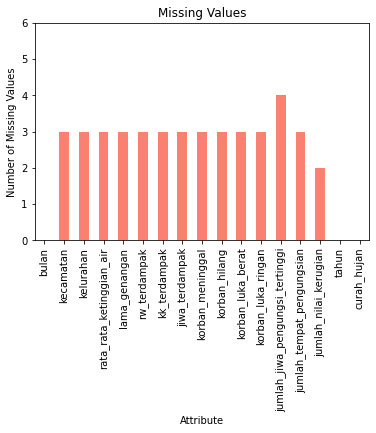

In [296]:
ax = (df.isnull().sum().plot.bar(color='salmon'))
plt.title("Missing Values")
plt.ylabel("Number of Missing Values")
plt.xlabel("Attribute")
plt.yticks(np.arange(0, 7))
plt.show()

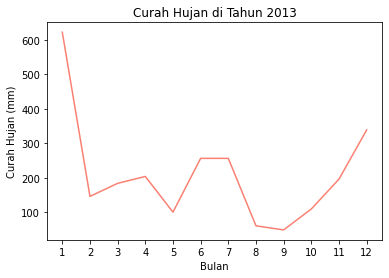

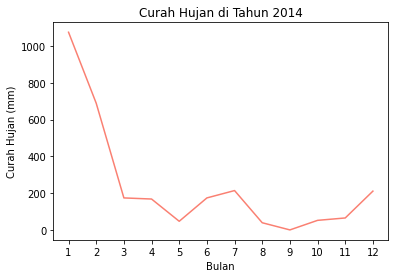

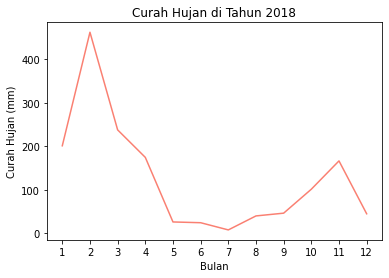

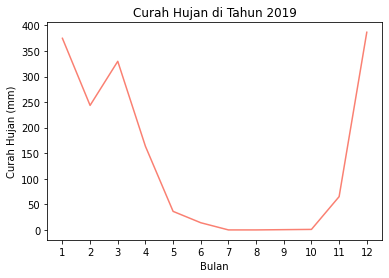

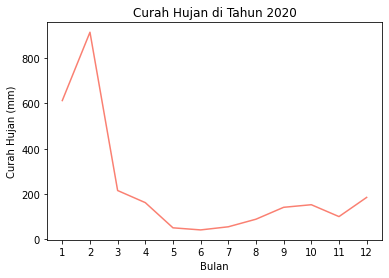

In [297]:
# Plot distribusi curah hujan di setiap tahun
def plot_monthly_data(df, year):
    df1 = df.loc[df['tahun']== year]
    df1.set_index('bulan', inplace=True)
    plt.plot(df1['curah_hujan'],color='salmon',label='Curah Hujan')
    plt.title('Curah Hujan di Tahun {}'.format(year))
    plt.xlabel('Bulan')
    plt.xticks(np.arange(1,13))
    plt.ylabel('Curah Hujan (mm)')
    plt.show()

for year in year_list:
    plot_monthly_data(df, year)

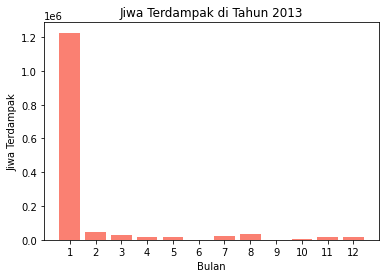

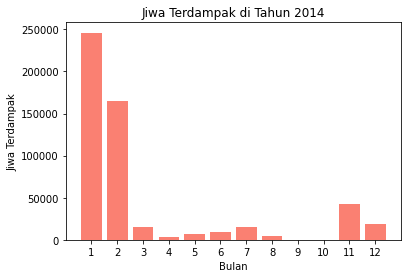

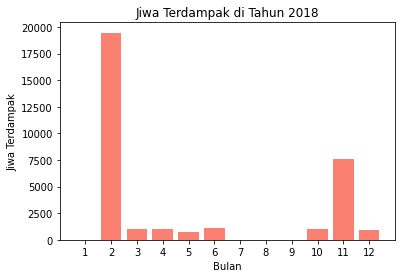

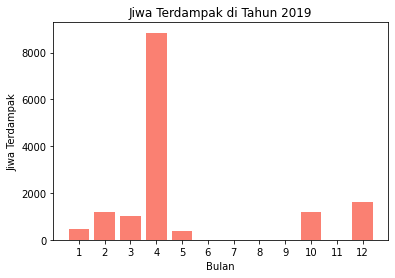

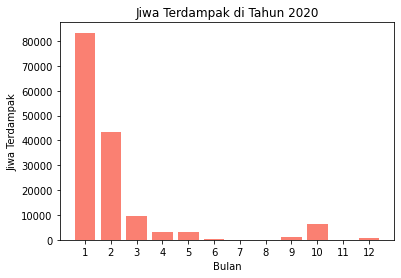

In [298]:
# Plot jiwa terdampak di setiap tahun
def plot_monthly_data(df, year):
    df1 = df.loc[df['tahun']== year]
    plt.bar(df1['bulan'],df1['jiwa_terdampak'],color='salmon',label='Jiwa Terdampak')
    plt.title('Jiwa Terdampak di Tahun {}'.format(year))
    plt.xlabel('Bulan')
    plt.xticks(np.arange(1,13))
    plt.ylabel('Jiwa Terdampak')
    plt.show()

for year in year_list:
    plot_monthly_data(df, year)

## Data Preprocessing

Data Preprocessing dibagi menjadi tiga langkah:
1. **Removing uninformative columns** - Menghapus kolom yang tidak berhubungan atau memiliki value yang sama di setiap record.
2. **Correcting Data Formatting** - Melakukan koreksi terhadap format values yang tidak relevan.
3. **Replace missing values** - Melakukan impute terhadap missing values dengan median di atribut terkait.
4. **Attribute Scaling** - Normalisasi atribut agar dalam skala yang sama saat diproses

In [299]:
# Drop kolom yang tidak diperlukan
df = df.drop(['rw_terdampak','korban_meninggal','korban_luka_berat','korban_luka_ringan','korban_hilang','jumlah_jiwa_pengungsi_tertinggi','jumlah_tempat_pengungsian','kecamatan','kelurahan','jumlah_nilai_kerugian','kk_terdampak'],axis=1)
df = df[df.rata_rata_ketinggian_air != '0']
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

# Koreksi format di kolom rata-rata ketinggian air
df['rata_rata_ketinggian_air'] = df['rata_rata_ketinggian_air'].str.replace('Oct-80','10-80')
df['rata_rata_ketinggian_air'] = df['rata_rata_ketinggian_air'].str.replace('May-90','5-90')  
for value in df['rata_rata_ketinggian_air']:
    if pd.isnull(value):
        continue
    numbers = re.findall(r'\d+', value)
    numbers_in_integer = map(int,numbers)
    new_value = round(np.average(list(numbers_in_integer)),2)
    df['rata_rata_ketinggian_air'] = df['rata_rata_ketinggian_air'].replace(value, new_value)

# Koreksi format di kolom lama genangan
for value in df['lama_genangan']:
    if pd.isnull(value) or type(value) != str:
        continue
    numbers = re.findall(r'\d+', value)
    numbers_in_integer = map(int,numbers)
    new_value = round(np.average(list(numbers_in_integer)),0)
    df['lama_genangan'] = df['lama_genangan'].replace(value, new_value)

# Replace missing values
df.replace('NaN', np.nan, inplace=True)
imp_med = SimpleImputer(missing_values=np.NaN, strategy='median')
imputer = imp_med.fit(df)
df_imp = imputer.transform(df)
df = pd.DataFrame(df_imp, columns=df.columns)

# Split dataframe menjadi feature dan target
df_data = df.drop(['rata_rata_ketinggian_air'],axis=1)
df_target = df['rata_rata_ketinggian_air']  

# Attribute scaling
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(df_data.values) 
df_scaled = pd.DataFrame(x_scaled, index = df_data.index,columns=df_data.columns)

## Split data into train-test

Sebelum membuat model machine learning, kita split data menjadi data training dan data testing.
Dengan menggunakan _preprocessed dataframe_, pembagiannya sebagai berikut:
* Train - 85%
* Test - 15%

In [300]:
# Split data ke dalam data train dan data test
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled, df_target,shuffle=True, test_size=0.1, random_state=42)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(46, 5) (46,) (6, 5) (6,)


## Random Forest Regressor
Model algoritma ini bekerja dengan menggunakan gabungan dari banyak _decision tree_ untuk melakukan prediksi. Dengan penggabungan tersebut, model dapat memberikan prediksi yang akurat dan stabil.

Random Forest MSE:  896.2783375000002
Random Forest MAE:  24.4575
Random Forest R2 Score:  0.6564932314857941


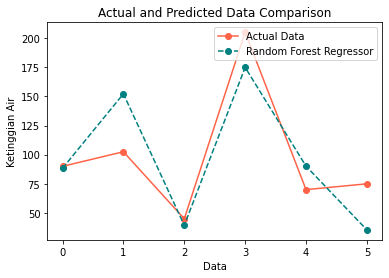

In [301]:
# Buat model regresi random forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, Y_train)
rf_preds = rf_model.predict(X_test)

# Kalkulasi nilai MSE, MAE, dan R2
mse_rf = mean_squared_error(Y_test, rf_preds)
mae_rf = mean_absolute_error(Y_test, rf_preds)
r2_rf = r2_score(Y_test, rf_preds)

# Cetak nilai MSE, MAE, dan R2
print('Random Forest MSE: ', mse_rf)
print('Random Forest MAE: ', mae_rf)
print('Random Forest R2 Score: ', r2_rf)

# Plot hasil prediksi
plt.plot(range(len(Y_test)), Y_test,'-o',color='tomato')
plt.plot(range(len(rf_preds)), rf_preds,'--o',color='teal')
plt.legend(['Actual Data', 'Random Forest Regressor'], loc='upper right')
plt.title('Actual and Predicted Data Comparison')
plt.ylabel('Ketinggian Air')
plt.xlabel('Data')
plt.show()

## Linear Regression
Model algoritma ini bekerja dengan melihat pola hubungan antara variabel prediktor dan variabel dependen. Penggunaan ini berdasar dengan adanya asumsi hubungan linier antara data atribut dengan target prediksi

Linear Regression MSE:  313.6074308105866
Linear Regression MAE:  12.29304323765101
Linear Regression R2 Score:  0.8798071194710906


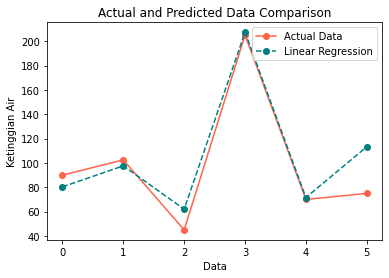

In [302]:
# Buat model regresi linear
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X_train, Y_train)
lr_preds = lr_model.predict(X_test)

# Kalkulasi nilai MSE, MAE, dan R2
mse_lr = mean_squared_error(Y_test, lr_preds)
mae_lr = mean_absolute_error(Y_test, lr_preds)
r2_lr = r2_score(Y_test, lr_preds)

# Cetak nilai MSE, MAE, dan R2
print('Linear Regression MSE: ', mse_lr)
print('Linear Regression MAE: ', mae_lr)
print('Linear Regression R2 Score: ', r2_lr)

# Plot hasil prediksi
plt.plot(range(len(Y_test)), Y_test,'-o',color='tomato')
plt.plot(range(len(lr_preds)), lr_preds,'--o',color='teal')
plt.legend(['Actual Data', 'Linear Regression'], loc='upper right')
plt.title('Actual and Predicted Data Comparison')
plt.ylabel('Ketinggian Air')
plt.xlabel('Data')
plt.show()

## Models Performance Comparison

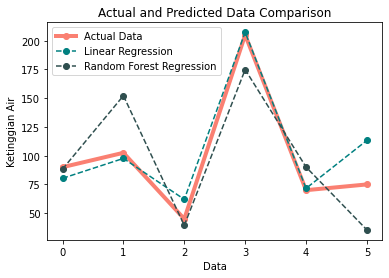

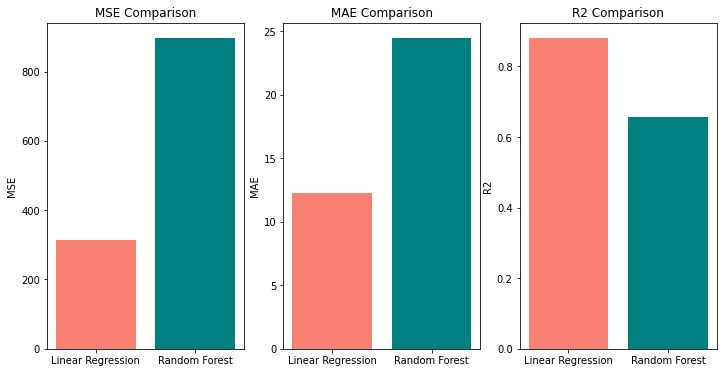

In [303]:
def plotGraph(y_test,y_pred,y_pred2,regressor1,regressor2):
    plt.plot(range(len(y_test)), y_test,'-o',color='salmon',linewidth=4)
    plt.plot(range(len(y_pred)), y_pred,'--o',color='teal')
    plt.plot(range(len(y_pred2)), y_pred2,'--o',color='darkslategray')
    plt.legend(['Actual Data', regressor1,regressor2], loc='upper left')
    plt.title('Actual and Predicted Data Comparison')
    plt.ylabel('Ketinggian Air')
    plt.xlabel('Data')
    plt.show()
    return

plotGraph(Y_test, lr_preds,rf_preds,'Linear Regression','Random Forest Regression')

# Buat bar chart untuk membandingkan nilai MSE, MAE, dan R2 di antara kedua model
models = ['Linear Regression','Random Forest']
r2_scores = [r2_lr,r2_rf]
mae_scores = [mae_lr,mae_rf]
mse_scores = [mse_lr,mse_rf]

plt.figure(figsize=(12,6))

#subplot MSE
plt.subplot(1,3,1)
plt.bar(models, mse_scores, color=['salmon','teal'])
plt.title('MSE Comparison')
plt.ylabel('MSE')

#subplot MAE
plt.subplot(1,3,2)
plt.bar(models, mae_scores, color=['salmon','teal'])
plt.title('MAE Comparison')
plt.ylabel('MAE')

#subplot R2
plt.subplot(1,3,3)
plt.bar(models, r2_scores, color=['salmon','teal'])
plt.title('R2 Comparison')
plt.ylabel('R2')
plt.show()